**DIY FACIAL RECOGNITION MODELING SCRIPT**<BR>
This file allows the user to focus on modeling, rather than image collection and processing, by importing the downstream data files generated by the FaceRecog.jpynb script. There are similarities between these two scripts, but this file is faster and doesn't process any of the image files. Instead, it simply grabs pre-processed data, in the form of a csv file containing Euclidean distances which are calculated from the original image files.

# **Import Packages**

In [15]:
import pandas as pd
import numpy as np
import random
import math
from copy import deepcopy

# for timing model builds
import time

# predictive modeling
from sklearn.ensemble import RandomForestClassifier

# for KNN block
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

# for confusion matrices
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#!pip install pathlib
import pathlib

# CNN
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
# !pip install keras
#!pip install tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# if colab, use output for sound
# settings for winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second

inColab = False
try:    
    # beep code https://stackoverflow.com/questions/54293537/is-there-a-way-to-make-colab-give-an-audio-notification-when-cell-has-finished-r
    from google.colab import output
    inColab = True
# if running at home, use winsound
except:
    import winsound


# **Declare Local Variables**

In [16]:
###################################################################################################################################
# LOCAL VARIABLES: YOU SHOULD NOT NEED TO CHANGE THESE, ASSUMING YOU HAVE UNZIPPED THE FILES AND NOT MOVED ANY ACCOMPANYING FOLDERS
###################################################################################################################################

# because I use dark mode, I use a contrasting color when printing text against the background. You can change this here
textColor = "#cccccc"

# the number of images to use 
targetImagesPerPerson = 110

pathToPoints = ""
srcFolder = ""

try:
  pathToPoints = "Data//points.csv"

  allPoints = pd.read_csv(pathToPoints)
except:
  pathToPoints = "points.csv"

# **Define local functions**

In [17]:
# make a beep in either colab or otherwise
# sound functions for Colab https://stackoverflow.com/questions/54293537/is-there-a-way-to-make-colab-give-an-audio-notification-when-cell-has-finished-r
def makeBeep(isColab):
  if isColab:
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/transcoded/f/f9/Beep_example.ogg/Beep_example.ogg.mp3").play()')
  else:
    winsound.Beep(frequency, duration) 

# **Get data from points.csv file**

In [18]:
# get all data
allPoints = pd.read_csv(pathToPoints)
newCols = allPoints.columns[1:len(allPoints.columns)] # remember the columns we want to keep
allPoints.set_index("Unnamed: 0", inplace=False) # reset the index to the first column's values
allPoints = allPoints[newCols] # remove the old index column

# **Scrub**

In [19]:
##########################################################################################################################
# CLEAN UP DIFFERENT PERSON NAMES
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

# determine which columns we reall need
colsToKeep = ["person"] + list(allPoints.columns[2:len(allPoints.columns)])

ad = allPoints[colsToKeep]                       # get a local copy of allDistances df
ad["person"] = ad["person"].apply(str.lower)        # change case of person to lower

# fix person names where they are duplicates
ad["person"][ad["person"] == "sandras"] = "sandys"  
ad["person"][ad["person"] == "andrew"] = "andrewd"  
ad["person"][ad["person"] == "anniet"] = "annieti"  
ad["person"][ad["person"] == "davidl"] = "davidla"  
ad["person"][ad["person"] == "garenm"] = "garenmo"  
ad["person"][ad["person"] == "jiebin"] = "jiebinz"  
ad["person"][ad["person"] == "joshua"] = "joshuab"  
ad["person"][ad["person"] == "karltr"] = "karltre"  
ad["person"][ad["person"] == "katieh"] = "katieha"  
ad["person"][ad["person"] == "leiche"] = "leichen"  
ad["person"][ad["person"] == "nickwa"] = "nickwai"
ad["person"][ad["person"] == "noahla"] = "noahlar"
ad["person"][ad["person"] == "noefer"] = "noefern"
ad["person"][ad["person"] == "sethri"] = "sethris"

C:\Users\KETRE~1.WIN\AppData\Local\Temp/ipykernel_15824/10544640.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad["person"] = ad["person"].apply(str.lower)        # change case of person to lower
C:\Users\ketre.WINDOWS-H8826EH\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [20]:
#################
# get y variables
#################

personIDs = ad["person"].unique()
personIDs = pd.DataFrame(personIDs)
personIDs = personIDs.reset_index()
personIDs.columns = ("ID", "person")

y = ad["person"]
y = pd.DataFrame(y)

In [21]:
#################
# get X variables
#################

# make a 330 x 330 image with just the dots
# shrink that image to 28 pixels
# show the image
def getx(coords):
  return(int(coords.split(",")[0].replace("[", "")))

def gety(coords):
  return(int(coords.split(",")[1].replace("]", "")))


# for every image in the dataset

# create dataframe with a single row to hold all pixels in a 28x28 image
matrixCols = 28
matrixRows = 28

cols = ad.columns
colLength = len(cols)-1

X = []

# for every row in the ad dataframe
for i in range(0,len(ad)):
  # get all coordinates for an image
  allCoords = ad.iloc[i][2:colLength]

  r = [0] * (matrixCols*matrixRows)
  r = pd.DataFrame(r).transpose()

  # for every coordinate with a point
  for coord in allCoords:
    _x = round(getx(coord)/12)-1
    _y = round(gety(coord)/12)-1
    point = (matrixCols-1) * _y + _x
    r.iloc[0][point] = 255

  # add the new "row" to the list of rows
  X.append(list(r.iloc[0]))

# get dataframe version so we can show the images, too.
X = pd.DataFrame(X)



# **Explore/Visualize**

Transformation: 68 point matrices to 28x28 pixel images


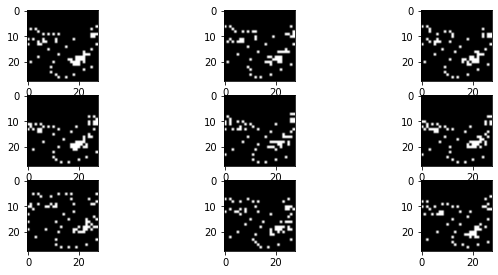

In [22]:
##############################################
# SHOW FIRST 9 ITEMS OF DATA
##############################################

# mostly from https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python
print("Transformation: 68 point matrices to 28x28 pixel images")
for i in range(100,109):  
  img = np.reshape(list(X.iloc[i]), (28, 28)) # https://thispointer.com/python-convert-a-1d-array-to-a-2d-numpy-array-or-matrix/
  plt.subplot(330 + 1 + i)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  
plt.show()


# **Transform**

In [9]:
#########################
# SHUFFLE THE DATA
#########################

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X.iloc[permutation]
y.iloc[permutation]
X = X.values.reshape((X.shape[0], -1))

In [10]:
############################################################################
# rework y data so that it's a categorical series, suitable for CNN function
############################################################################

def getID(person):
  try:
    return(int((personIDs.loc[personIDs["person"] == person])["ID"]))
  except:
    return -1

y["person"] = y["person"].apply(getID)

# turn y into a series - https://datatofish.com/pandas-dataframe-to-series/
y = y.squeeze()
# make y categorical
y = y.astype("category")

In [11]:
#########################################
# RESIZE DATASET AND GET TRAIN/TEST SPLIT
#########################################
# determine the percent split
pctSplit = .8 # 80/20 split

#train_samples=6000
train_samples= int(len(X) * pctSplit)

# get the test samples
test_samples = int(train_samples * (1-pctSplit) )

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=test_samples)

# **Build Convolutional Neural Network**

In [24]:
# code from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
np.random.seed(42)
k=5

#epochs = 5
#epochs = 10 # mean (no dropout) = 90.31; (.10 dropout) = 90.6 
epochs = 50 # mean (no dropout) = 90.99%; (.10 dropout) = 90.28; (.05 dropout) = 90.66%
#epochs = 100 # mean (no dropout) = 90.48%; (.10 dropout) = 

# scale pixels
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(22, activation='softmax')) 
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=k, modelName = ""):
  scores, histories = list(), list()
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model		
    startTime = time.time() # time the process
    model = define_model()
    endTime = time.time()
    elapsedTime = round(endTime - startTime, 4)  
		
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_data=(testX, testY), verbose=0) 
   
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print("\n{} model elapsed time={} seconds. Accuracy: {:.2f}%".format(modelName, elapsedTime, round((acc * 100.0), 2))) 	
    #print('> %.3f' % (acc * 100.0))

    # append scores
    scores.append(acc)
    histories.append(history)
  return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.rcParams["figure.figsize"] = (10,6)
    plt.title('Cross Entropy Loss', color=textColor)
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.xticks(color=textColor)
    plt.yticks(color=textColor)
    plt.grid()
    plt.xlabel(xlabel="Epoch", color=textColor)
    plt.ylabel(ylabel="Entropy", color=textColor)
    plt.show()

    # plot accuracy
    plt.rcParams["figure.figsize"] = (10,6)
    plt.title('\n\nClassification Accuracy', color=textColor)
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.xticks(color=textColor)
    plt.yticks(color=textColor)
    plt.grid()
    plt.xlabel(xlabel="Epoch", color=textColor)
    plt.ylabel(ylabel="Accuracy", color=textColor)
    plt.show()

# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

# run the test harness for evaluating a model
def run_test_harness(trainX, trainY, testX, testY, modelName=""):
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)  
  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # evaluate model
  scores, histories = evaluate_model(trainX, trainY, 5, modelName)
  # learning curves
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)

# entry point, run the test harness with standard set
print("\nStarting standard set CNN:")
run_test_harness(np.array(X_train), y_train, np.array(X_test), y_test, "Standard set CNN")

makeBeep(inColab)




Starting standard set CNN:


TypeError: Invalid keyword arguments: ['random_state']